<a href="https://colab.research.google.com/github/Emilie-Jessen/AppML-Final-Project-2024/blob/main/EfficientNet_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2B3
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.layers import Lambda, Dense, InputLayer, Rescaling, Dropout, Flatten
from tensorflow.keras import Sequential

In [3]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# The pictures are 48x48 pixels, but the model requires 128x128 pixels

input_pixels = 48
model_pixels = 128
IMAGE_SIZE = (input_pixels, input_pixels)
RE_SIZE = (model_pixels, model_pixels)
BATCH_SIZE = 16

In [25]:
# Load the images from the test folder and create a dataset

def build_trainset(subset):
    return image_dataset_from_directory(
                        f"drive/MyDrive/archive/train",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42,
                        validation_split=0.2,
                        subset=subset)

Found 30719 files belonging to 7 classes.
Using 24576 files for training.
Found 30719 files belonging to 7 classes.
Using 6143 files for validation.


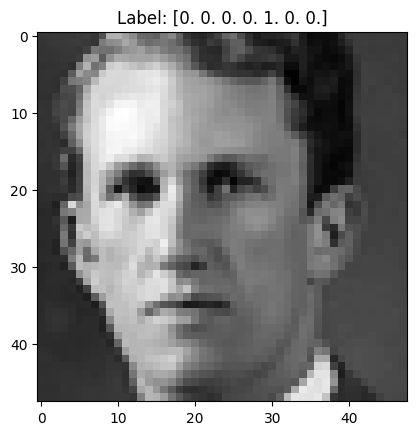

(1, 48, 48, 1)


In [26]:
# Load the training and validation datasets
train_ds = build_trainset("training")
val_ds = build_trainset("validation")

# Get the names of the labels
class_names = tuple(train_ds.class_names)

# Print one image
for image, label in train_ds.take(1):
    plt.imshow(image[0], cmap='gray')
    plt.title(f"Label: {label[0]}")
    plt.show()

# Print the shape of the images
for image, label in train_ds.take(1):
    print(image.shape)

In [9]:
print(class_names)

('angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised')


In [10]:
# Define augmentation function
def augment1(image):
    image = tf.image.random_flip_left_right(image)
    return image

def augment2(image):
    image = tf.image.random_flip_up_down(image)
    return image

def augment3(image):
    image = tf.image.rot90(image, k=1)
    return image

def augment4(image):
    image = tf.image.rot90(image, k=3)
    return image

def augment5(image):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=3)
    return image

augment_data = False

if augment_data:
  # Apply augmentation conditionally
  augmented_dataset = []

  for image, label in train_ds.take(len(train_ds)):
    if np.argmax(label, axis=1) == 1:
      augmented_dataset.append(augment1(image))
      augmented_dataset.append(augment2(image))
      augmented_dataset.append(augment3(image))
      augmented_dataset.append(augment4(image))
      augmented_dataset.append(augment5(image))


In [24]:
# Save the augmented images in the archive/train/aug_disgusted folder

save_augmented_data = False
if save_augmented_data:
  with tf.device('/device:CPU:0'):
    for i, image in enumerate(augmented_dataset):
        tf.keras.preprocessing.image.save_img(f"drive/MyDrive/archive/train/disgusted/augmented_img{i}.png", image[0])

In [27]:
# Preprocessing of the data

# The pictures are 48x48 pixels, but the model requires 128x128 pixels
resize_layer = Lambda(lambda x: smart_resize(x, size=RE_SIZE))

# The model requires 3 channels, so we need to convert the grayscale image to RGB
grayscale_to_rgb_layer = Lambda(lambda x: grayscale_to_rgb(x))

# Create preprocessing model
preprocessing_model = Sequential()
preprocessing_model.add(resize_layer)
preprocessing_model.add(grayscale_to_rgb_layer)

In [ ]:
# Enhance the contrast of the images
def enhance_contrast(image):
    return tf.image.adjust_contrast(image, 2)

# Apply the contrast enhancement
train_ds = train_ds.map(lambda x, y: (enhance_contrast(x), y))
val_ds = val_ds.map(lambda x, y: (enhance_contrast(x), y))

In [28]:
# Apply the preprocessing model to the training and validation datasets
train_ds = train_ds.map(lambda image, label: (preprocessing_model(image), label))
val_ds = val_ds.map(lambda image, label: (preprocessing_model(image), label))

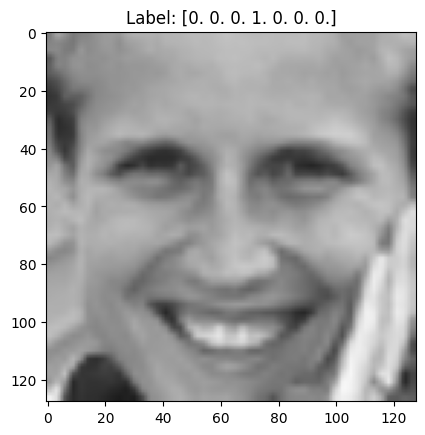

(1, 128, 128, 3)


In [29]:
# Print the same image after preprocessing
for image, label in train_ds.take(1):
    plt.imshow(image[0]*1/255)
    plt.title(f"Label: {label[0]}")
    plt.show()

# Print the shape of the images after preprocessing
for image, label in train_ds.take(1):
    print(image.shape)

In [30]:
# Get class names and the size of the data sets
train_size = train_ds.cardinality().numpy()
val_size = val_ds.cardinality().numpy()

train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# Repeat training data set to ensure enough data
train_ds = train_ds.repeat()

In [31]:
# Load the EfficientNetV2 model as the base model and freeze the weights
# Don't add top layer and add our own top

base_model = EfficientNetV2B3(input_shape=(model_pixels, model_pixels, 3),
                             include_top=False,
                             weights='imagenet',
                             pooling=None)

base_model.trainable = False

# Add layers on top of the base model
model = Sequential([base_model,
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(len(class_names), kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='softmax')])

# Build the model
model.build((None,)+(model_pixels, model_pixels)+(3,))
model.summary()

52606240/52606240 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 4, 4, 1536)        12930622  
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 1024)              25166848  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               

In [32]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [33]:
steps_per_epoch = train_size // (BATCH_SIZE * 2)
validation_steps = val_size // BATCH_SIZE

print(steps_per_epoch)
print(train_size)

768
24576


In [35]:
# Train the model

# Implement early stopping with patience 3
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

with tf.device('/device:GPU:0'):
  hist = model.fit(train_ds,
                   batch_size=BATCH_SIZE,
                   epochs=10,
                   steps_per_epoch=steps_per_epoch,
                   validation_data=val_ds,
                   validation_steps=validation_steps,
                   callbacks=[early_stopping]).history

Epoch 1/10
768/768 [==============================] - 924s 1s/step - loss: 1.6950 - accuracy: 0.3943 - val_loss: 1.3703 - val_accuracy: 0.4796
Epoch 2/10
768/768 [==============================] - 523s 682ms/step - loss: 1.4222 - accuracy: 0.4660 - val_loss: 1.2786 - val_accuracy: 0.5095
Epoch 3/10
768/768 [==============================] - 28s 37ms/step - loss: 1.3080 - accuracy: 0.5120 - val_loss: 1.2613 - val_accuracy: 0.5307
Epoch 4/10
768/768 [==============================] - 28s 37ms/step - loss: 1.2863 - accuracy: 0.5183 - val_loss: 1.2601 - val_accuracy: 0.5189
Epoch 5/10
768/768 [==============================] - 29s 37ms/step - loss: 1.2077 - accuracy: 0.5540 - val_loss: 1.1842 - val_accuracy: 0.5620
Epoch 6/10
768/768 [==============================] - 28s 37ms/step - loss: 1.1888 - accuracy: 0.5596 - val_loss: 1.2116 - val_accuracy: 0.5542
Epoch 7/10
768/768 [==============================] - 28s 37ms/step - loss: 1.1333 - accuracy: 0.5789 - val_loss: 1.2058 - val_accuracy

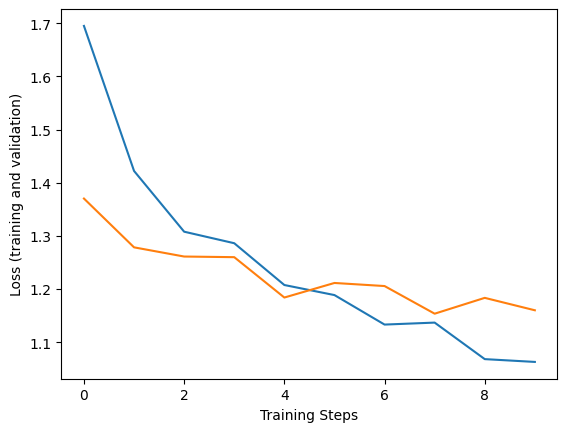

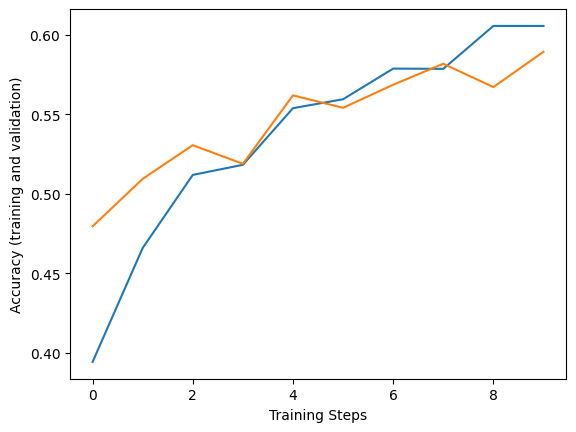

In [36]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
#plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

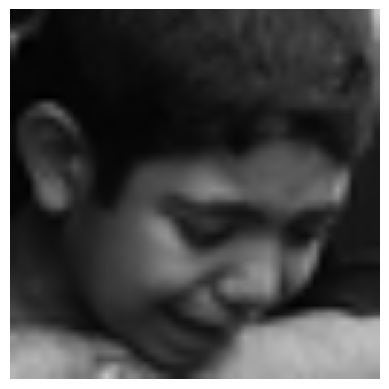

1/1 [==============================] - 3s 3s/step
True label: sad
Predicted label: neutral


In [37]:
x, y = next(iter(val_ds))
image = x[0, :, :, :] * 1 / 255
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [38]:
def build_testset():
    return image_dataset_from_directory(
                        f"drive/MyDrive/archive/test",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42)

In [39]:
# Build test set
test_ds = build_testset()

# Apply the preprocessing model to the test dataset
test_ds = test_ds.map(lambda x, y: (preprocessing_model(x), y))

# Get the test set size
test_size = test_ds.cardinality().numpy()

# Predict the labels of the test dataset
y_pred = model.predict(test_ds, verbose=1)

# Get the loss and accuracy of the model on the test dataset
loss, accuracy = model.evaluate(test_ds, verbose=1)

print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Found 7178 files belonging to 7 classes.
7178/7178 [==============================] - 101s 14ms/step - loss: 1.1965 - accuracy: 0.5694
Test loss: 1.1965031623840332
Test accuracy: 0.569378674030304


In [40]:
# Get the true labels of the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Get the predicted labels
y_pred = np.argmax(y_pred, axis=1)

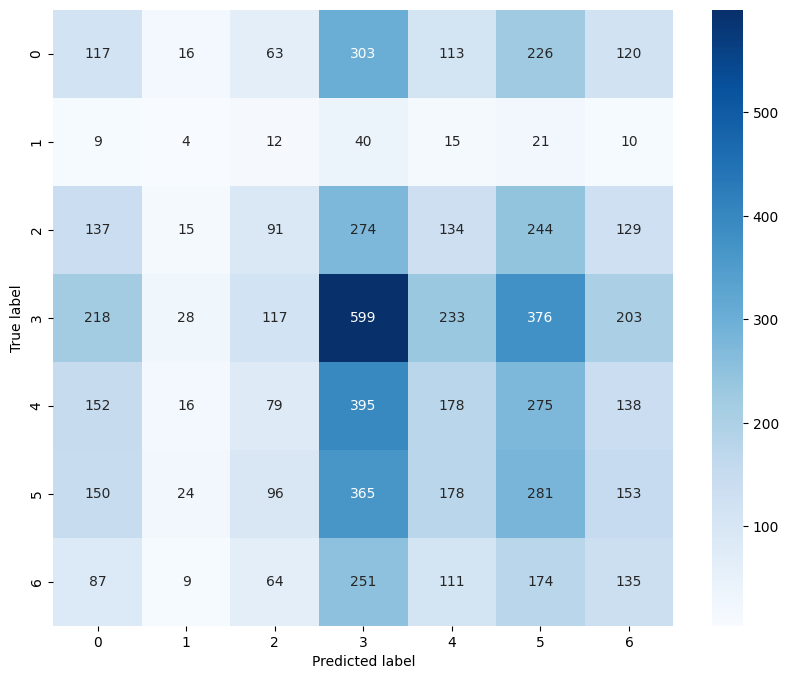

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [42]:
# Calculate accuracy
y_pred = np.array(y_pred)
y_true = np.array(y_true)

label_diff = y_pred - y_true
correct_predictions = len(y_true) - np.count_nonzero(label_diff)

accuracy = correct_predictions / len(y_true)

print(accuracy)

0.19573697408748955


In [43]:
# Find out accuracy of each class

class_acc = np.zeros(len(cm))

for i in range(len(cm)):
  class_acc[i] = cm[i, i] / np.sum(cm[i, :])

print(class_acc)

[0.12212944 0.03603604 0.08886719 0.33765502 0.14436334 0.22534082
 0.16245487]


In [44]:
# Find out if this method works for saving the model

model.save("efficientnet_v2_incl_data_aug.keras")

1/1 [==============================] - 0s 36ms/step


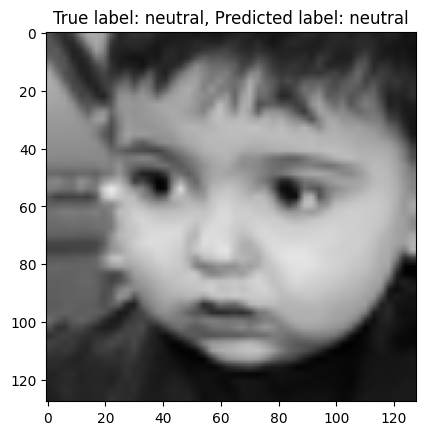

In [47]:
for image, label in test_ds.take(1):
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    plt.imshow(image[0]*1/255)
    plt.title(f"True label: {class_names[np.argmax(label[0])]}, Predicted label: {class_names[predicted_label[0]]}")
    plt.show()

Without disgusted

Found 28383 files belonging to 6 classes.
Using 22707 files for training.
Found 28383 files belonging to 6 classes.
Using 5676 files for validation.


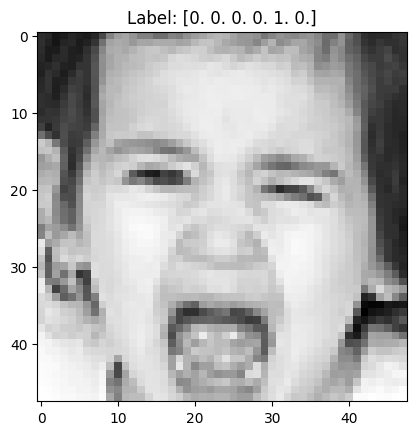

(1, 48, 48, 1)


In [55]:
# Load the training and validation datasets
train_ds = build_trainset("training")
val_ds = build_trainset("validation")

# Get the names of the labels
class_names = tuple(train_ds.class_names)

# Print one image
for image, label in train_ds.take(1):
    plt.imshow(image[0], cmap='gray')
    plt.title(f"Label: {label[0]}")
    plt.show()

# Print the shape of the images
for image, label in train_ds.take(1):
    print(image.shape)

In [56]:
class_names

('angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised')

In [57]:
# Apply the preprocessing model to the training and validation datasets
train_ds = train_ds.map(lambda image, label: (preprocessing_model(image), label))
val_ds = val_ds.map(lambda image, label: (preprocessing_model(image), label))

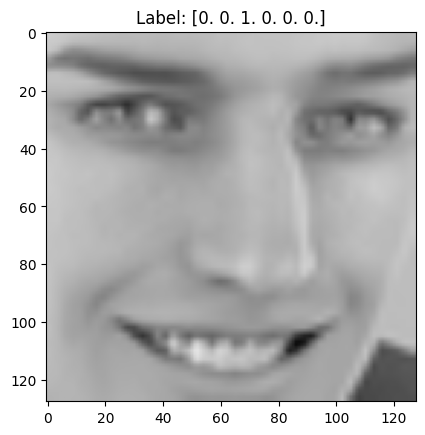

(1, 128, 128, 3)


In [58]:
# Print the same image after preprocessing
for image, label in train_ds.take(1):
    plt.imshow(image[0]*1/255)
    plt.title(f"Label: {label[0]}")
    plt.show()

# Print the shape of the images after preprocessing
for image, label in train_ds.take(1):
    print(image.shape)

In [59]:
# Get class names and the size of the data sets
train_size = train_ds.cardinality().numpy()
val_size = val_ds.cardinality().numpy()

train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# Repeat training data set to ensure enough data
train_ds = train_ds.repeat()

In [63]:
# Load the EfficientNetV2 model as the base model and freeze the weights
# Don't add top layer and add our own top

base_model = EfficientNetV2B3(input_shape=(model_pixels, model_pixels, 3),
                             include_top=False,
                             weights='imagenet',
                             pooling=None)

base_model.trainable = False

# Add layers on top of the base model
model = Sequential([base_model,
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(6, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='softmax')])

# Build the model
model.build((None,)+(model_pixels, model_pixels)+(3,))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 4, 4, 1536)        12930622  
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 24576)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              25166848  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [64]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [65]:
steps_per_epoch = train_size // (BATCH_SIZE * 2)
validation_steps = val_size // BATCH_SIZE

print(steps_per_epoch)
print(train_size)

709
22707


In [66]:
# Train the model

# Implement early stopping with patience 3
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

with tf.device('/device:GPU:0'):
  hist = model.fit(train_ds,
                   batch_size=BATCH_SIZE,
                   epochs=20,
                   steps_per_epoch=steps_per_epoch,
                   validation_data=val_ds,
                   validation_steps=validation_steps,
                   callbacks=[early_stopping]).history

Epoch 1/20
709/709 [==============================] - 81s 97ms/step - loss: 1.6767 - accuracy: 0.4027 - val_loss: 1.2716 - val_accuracy: 0.5025
Epoch 2/20
709/709 [==============================] - 26s 36ms/step - loss: 1.3714 - accuracy: 0.4754 - val_loss: 1.2181 - val_accuracy: 0.5237
Epoch 3/20
709/709 [==============================] - 26s 37ms/step - loss: 1.2882 - accuracy: 0.5072 - val_loss: 1.1641 - val_accuracy: 0.5512
Epoch 4/20
709/709 [==============================] - 25s 36ms/step - loss: 1.2490 - accuracy: 0.5234 - val_loss: 1.1501 - val_accuracy: 0.5600
Epoch 5/20
709/709 [==============================] - 25s 36ms/step - loss: 1.1873 - accuracy: 0.5430 - val_loss: 1.1631 - val_accuracy: 0.5646
Epoch 6/20
709/709 [==============================] - 25s 36ms/step - loss: 1.1696 - accuracy: 0.5555 - val_loss: 1.1311 - val_accuracy: 0.5726
Epoch 7/20
709/709 [==============================] - 25s 36ms/step - loss: 1.1193 - accuracy: 0.5804 - val_loss: 1.1524 - val_accuracy:

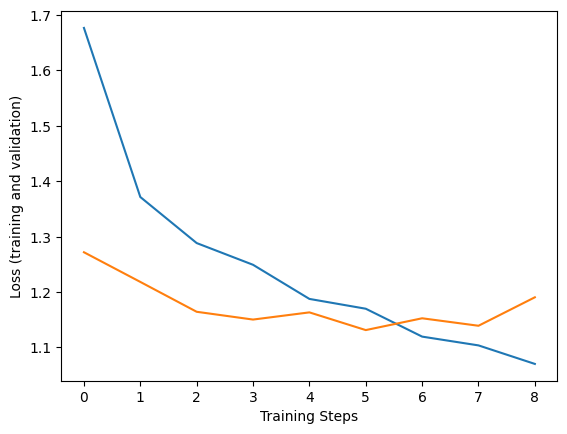

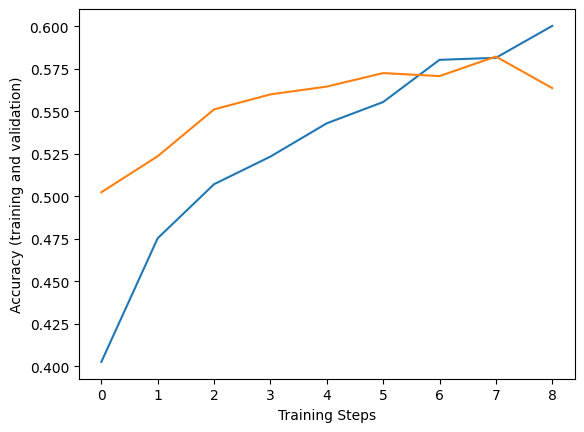

In [67]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
#plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

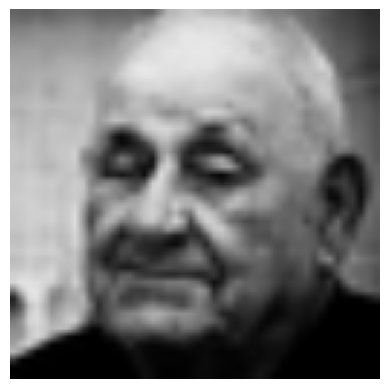

1/1 [==============================] - 3s 3s/step
True label: neutral
Predicted label: neutral


In [68]:
x, y = next(iter(val_ds))
image = x[0, :, :, :] * 1 / 255
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [69]:
def build_testset():
    return image_dataset_from_directory(
                        f"drive/MyDrive/archive/test",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42)

In [70]:
# Build test set
test_ds = build_testset()

# Apply the preprocessing model to the test dataset
test_ds = test_ds.map(lambda x, y: (preprocessing_model(x), y))

# Get the test set size
test_size = test_ds.cardinality().numpy()

# Predict the labels of the test dataset
y_pred = model.predict(test_ds, verbose=1)

# Get the loss and accuracy of the model on the test dataset
loss, accuracy = model.evaluate(test_ds, verbose=1)

print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Found 7067 files belonging to 6 classes.
7067/7067 [==============================] - 101s 14ms/step - loss: 1.1326 - accuracy: 0.5633
Test loss: 1.1325910091400146
Test accuracy: 0.5633224844932556


In [71]:
# Get the true labels of the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Get the predicted labels
y_pred = np.argmax(y_pred, axis=1)

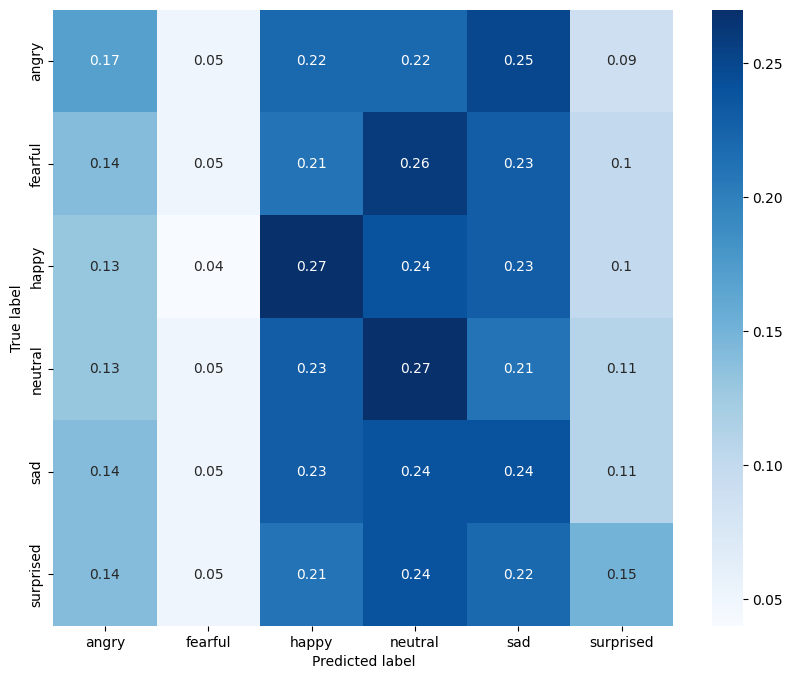

In [92]:
cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(np.round(cm, 2), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(0.5, 6.5, 1), class_names)
plt.yticks(np.arange(0.5, 6.5, 1), class_names)
plt.show()

In [74]:
# Find out accuracy of each class

class_acc = np.zeros(len(cm))

for i in range(len(cm)):
  class_acc[i] = cm[i, i] / np.sum(cm[i, :])

print(class_acc)

[0.1743215  0.05371094 0.26719278 0.27007299 0.24057739 0.14921781]


In [75]:
# Find out if this method works for saving the model

model.save("efficientnet_v2_without_disgusted.keras")

1/1 [==============================] - 0s 39ms/step


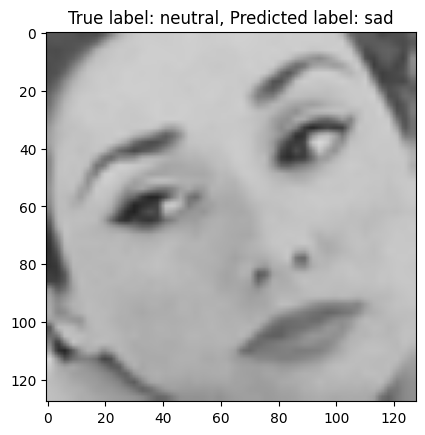

In [76]:
for image, label in test_ds.take(1):
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    plt.imshow(image[0]*1/255)
    plt.title(f"True label: {class_names[np.argmax(label[0])]}, Predicted label: {class_names[predicted_label[0]]}")
    plt.show()